# Random Forest Tuning (Descriptors + Fingerprints)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

import shap
import optuna

## Logging results

In [2]:
# Глобальный список для хранения всех результатов
all_results = []


def log_result(method_name, model_type, n_features, metrics, params=None, stage=None):
    """
    Сохраняет результаты в глобальную таблицу all_results.

    method_name — SHAP / MI / KBest / Lasso
    model_type — RF / OptunaRF / ExtraTrees / GBoost
    n_features — количество используемых фичей
    metrics — словарь метрик {"Accuracy":..., "F1":..., ...}
    params — словарь параметров модели
    stage — этап: baseline / final / optuna / simple_tuning
    """

    record = {
        "Method": method_name,
        "Model": model_type,
        "Stage": stage,
        "Top_Features": n_features,

        # Метрики
        "Accuracy": metrics.get("Accuracy"),
        "Precision": metrics.get("Precision"),
        "Recall": metrics.get("Recall"),
        "F1": metrics.get("F1"),
        "ROC_AUC": metrics.get("AUC"),
    }

    # Добавляем параметры модели, если есть
    if params is not None:
        for key, value in params.items():
            record[f"Param_{key}"] = value

    all_results.append(record)


def save_results_table(filename="all_results.xlsx"):
    """
    Преобразует global all_results → DataFrame и сохраняет таблицу.
    """
    df = pd.DataFrame(all_results)
    df.to_excel(filename, index=False)
    print(f"Saved full results table to {filename}")
    return df


## Molecule, Descriptor + Fingerprints and Outlier Functions

In [3]:
def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # Re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def bitvect_to_dict(fp, prefix):
    # Convert bit vector to dictionary (create features)
    n_bits = fp.GetNumBits()
    arr = np.zeros((n_bits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    features = {}
    for i, v in enumerate(arr):
        features[f"{prefix}_{i}"] = int(v)
    return features


def calculate_fingerprints(mol):
    RDLogger.DisableLog('rdApp.*')
    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    feats = {}
    if mol is None:
        return feats

    # Morgan (ECFP) fingerprint
    morgan_bits = 2048
    morgan_radius = 2
    fp_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol, radius=morgan_radius, nBits=morgan_bits
    )
    feats.update(bitvect_to_dict(fp_morgan, f"Morgan{morgan_radius}_{morgan_bits}"))

    # RDKit topological fingerprint
    rdk_bits = 2048
    fp_rdk = Chem.RDKFingerprint(mol, fpSize=rdk_bits)
    feats.update(bitvect_to_dict(fp_rdk, f"RDK_{rdk_bits}"))

    # MACCS keys (167 bits)
    fp_maccs = MACCSkeys.GenMACCSKeys(mol)
    feats.update(bitvect_to_dict(fp_maccs, "MACCS"))

    # AtomPair fingerprint
    ap_bits = 2048
    fp_ap = rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=ap_bits)
    feats.update(bitvect_to_dict(fp_ap, f"AtomPair_{ap_bits}"))

    # Topological torsion fingerprint
    tt_bits = 2048
    fp_tt = rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=tt_bits)
    feats.update(bitvect_to_dict(fp_tt, f"Torsion_{tt_bits}"))

    RDLogger.EnableLog('rdApp.*')

    return feats

## Dataset Processing

In [4]:
# Configuration
ORIG_DATASET = "in_vitro_3T3_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_vitro_3T3_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.65
# Correlation threshold
CORRELATION_THRESHOLD = 0.60

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        continue

    # 1D/2D RDKit descriptors
    desc_feats = calculate_descriptors(molecule)

    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    fp_feats = calculate_fingerprints(molecule)

    # Merge both dicts into one feature row
    all_feats = {**desc_feats, **fp_feats}
    descriptor_rows.append(all_feats)

# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
for column in X_full.columns:
    X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)

# Drop columns that are entirely NaN
all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_full = X_full.drop(columns=all_nan_cols)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

# print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
# print("First rows of train x:")
# print(X_train.head().to_string(index=False))
# print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
# print("First rows of train y:")
# print(y_train.head().to_string(index=False))
# X_train.describe()
#
# print("\nTrain set class counts:")
# print(y_train.value_counts())
# print("\nTrain set class ratio:")
# print(y_train.value_counts(normalize=True))
#
# print("\nTest set class counts:")
# print(y_test.value_counts())
# print("\nTest set class ratio:")
# print(y_test.value_counts(normalize=True))

Full - Rows: 397/Columns: 8585
                                                                                                   Name                                                                                                                                    IUPAC name CAS registry number      Structure  Phototoxicity                                                                     SMILES code                                                                                                                                                                              Sources  Note  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_

In [5]:
X_train.shape[1]

891

In [6]:
X_train.shape[0]

316

## Base Model Train

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Base Random Forest model
base_model = RandomForestClassifier(
    n_estimators=X_train.shape[1],
    random_state=42,
    class_weight="balanced"
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nRandom Forest performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Random Forest performance:
Accuracy:  0.7125
Precision: 0.7692
Recall:    0.5405
F1 score:  0.6349
ROC AUC:   0.8077

Classification report:
              precision    recall  f1-score   support

           0      0.685     0.860     0.763        43
           1      0.769     0.541     0.635        37

    accuracy                          0.713        80
   macro avg      0.727     0.701     0.699        80
weighted avg      0.724     0.713     0.704        80



## Feature Selection

PermutationExplainer explainer: 317it [1:19:47, 15.15s/it]                         
C:\Users\sirad\AppData\Local\Temp\ipykernel_18348\4064747932.py:50: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


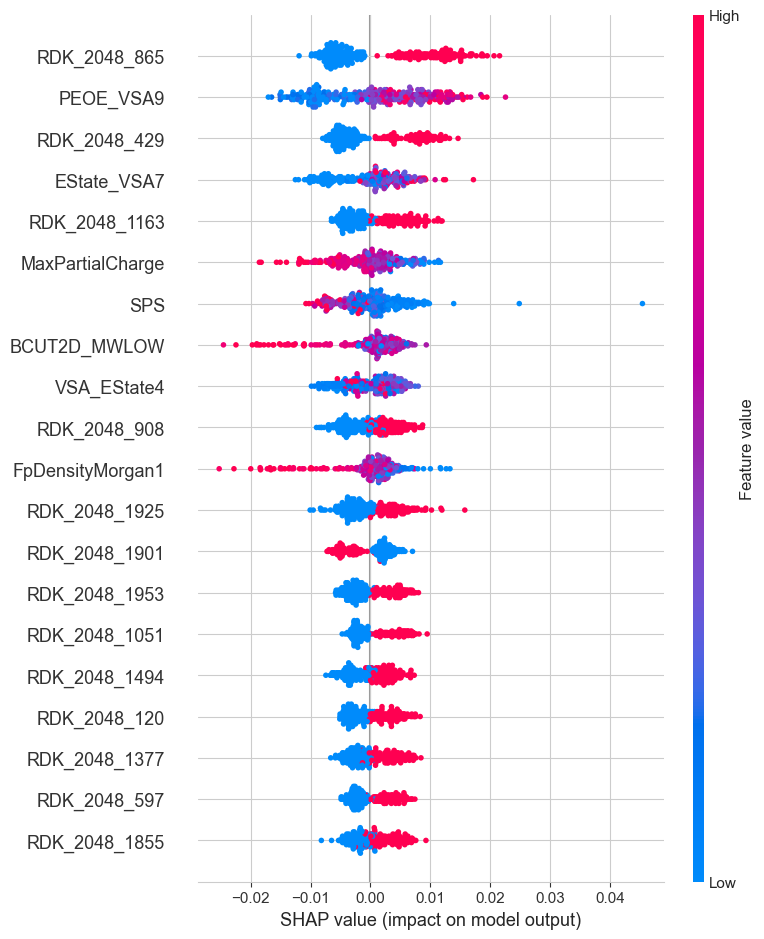


Top 10 SHAP features:
RDK_2048_865        0.007579
PEOE_VSA9           0.007280
RDK_2048_429        0.005414
EState_VSA7         0.004356
RDK_2048_1163       0.003847
MaxPartialCharge    0.003816
SPS                 0.003759
BCUT2D_MWLOW        0.003629
VSA_EState4         0.003425
RDK_2048_908        0.003411

Top 10 K-Best features:
RDK_2048_865     44.566735
RDK_2048_429     44.304678
RDK_2048_1051    30.789185
RDK_2048_1163    29.499950
RDK_2048_908     29.337498
RDK_2048_1377    28.699303
RDK_2048_120     28.565817
RDK_2048_1494    27.925924
RDK_2048_1953    27.783880
RDK_2048_1444    26.474817

Top 10 Lasso features:
RDK_2048_597          0.962426
RDK_2048_1901         0.747728
RDK_2048_1800         0.747414
AtomPair_2048_880     0.735080
RDK_2048_718          0.708941
RDK_2048_723          0.647506
SPS                   0.588224
AtomPair_2048_1636    0.580069
RDK_2048_429          0.570590
RDK_2048_865          0.506870


In [8]:
import shap
from sklearn.feature_selection import mutual_info_classif


# === 2. SHAP Importance ===
# SHAP ti ukazuje, ako každý príznak (MACCS bit) prispieva ku konečnej predikcii.
# Je to najinterpretovateľnejšia metóda (globálne aj lokálne).
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

shap_values = shap_result.values
shap_importance = np.abs(shap_values).mean(axis=0)

shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)


# === 3. Mutual Information (MI) ===
# MI meria, koľko informácie nesie každý príznak o cieľovej triede.
# Je veľmi stabilná metóda pre malé datasety a zmiešané typy príznakov.
mi_scores = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)

mi_features = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)


# === 4. ANOVA F-score (SelectKBest) ===
# ANOVA porovnáva priemerné hodnoty príznakov medzi triedami.
# Je to čistý štatistický pohľad – nezávislý od modelu.
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0)
kbest_features = kbest_scores.sort_values(ascending=False)

# === 5. Lasso Logistic Regression (L1 koeficienty) ===
# Lasso dáva lineárny pohľad na dôležitosť príznakov – veľké koeficienty = dôležitý príznak.
# Veľkou výhodou je, že zriedi nepotrebné príznaky (robí sparse model).
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# === 6. vizualizácia ===
shap.summary_plot(shap_values, X_train)

# Print best features for each method
print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())
print("\nTop 10 K-Best features:")
print(kbest_features.head(10).to_string())
print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())



## Evaluate Feature Method

In [9]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_rf_feature_method(method_name, feature_ranking, X_train, y_train, rf_model):
    """
    Универсальная функция кросс-валидации для Random Forest.
    method_name: 'SHAP', 'RF', 'KBest', 'Lasso'
    feature_ranking: pd.Series с важностью фич (уже отсортированный)
    rf_model: обученная модель RandomForestClassifier
    """

    print(f"\n===== Evaluating {method_name} feature ranking =====")

    results = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Цикл top-N: 5, 10, 15, ..., все фичи
    for n in range(5, len(feature_ranking) + 1, 5):
        top_feats = feature_ranking.head(n).index.tolist()

        # Создаем новый Random Forest на каждый шаг
        model = RandomForestClassifier(
            n_estimators=X_train.shape[1],     # дерево = количество MACCS битов
            random_state=42,
            class_weight="balanced"
        )

        # Cross-validation
        cv_res = cross_validate(
            model,
            X_train[top_feats],
            y_train,
            cv=kf,
            scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
            n_jobs=-1,
            return_train_score=False
        )

        mean_acc = cv_res["test_accuracy"].mean()
        mean_f1 = cv_res["test_f1"].mean()
        mean_auc = cv_res["test_roc_auc"].mean()

        results.append((n, mean_acc, mean_f1, mean_auc))

    # Таблица
    res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

    # Лучший N по F1
    best = res_df.iloc[res_df["CV_F1"].idxmax()]
    best_n = int(best.Top_N)

    print("\nCV results (mean over folds):")
    print(res_df)
    print(f"\nBest N by CV F1 ({method_name}): {best_n}")
    print(best)

    # График
    plt.figure(figsize=(7, 4))
    plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
    plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
    plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
    plt.xlabel(f"Number of top {method_name} features")
    plt.ylabel("Mean CV score")
    plt.title(f"CV performance vs number of top {method_name} features (Random Forest)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return best_n, res_df


===== Evaluating SHAP feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.683730  0.656055    0.740976
1       10     0.727927  0.703533    0.777117
2       15     0.731151  0.700108    0.801281
3       20     0.734276  0.705986    0.800926
4       25     0.731151  0.700899    0.798536
..     ...          ...       ...         ...
173    870     0.699554  0.644458    0.775223
174    875     0.715327  0.673192    0.779698
175    880     0.709028  0.667596    0.773175
176    885     0.702629  0.656654    0.775108
177    890     0.715278  0.675269    0.768102

[178 rows x 4 columns]

Best N by CV F1 (SHAP): 20
Top_N          20.000000
CV_Accuracy     0.734276
CV_F1           0.705986
CV_ROC_AUC      0.800926
Name: 3, dtype: float64


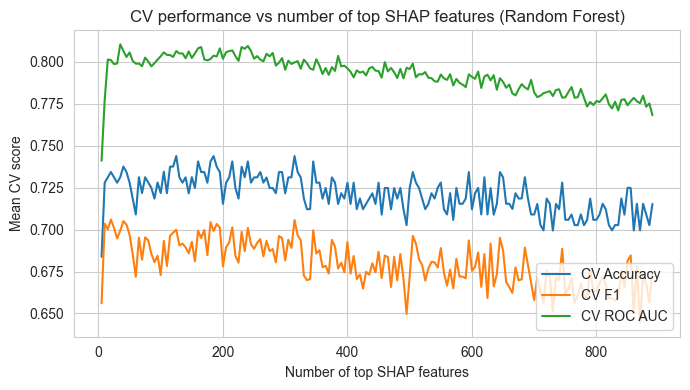


===== Evaluating MI feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.680605  0.647159    0.723125
1       10     0.696329  0.657640    0.729904
2       15     0.718502  0.669524    0.747778
3       20     0.728026  0.688043    0.748179
4       25     0.715476  0.665607    0.755817
..     ...          ...       ...         ...
173    870     0.702679  0.664635    0.774139
174    875     0.708978  0.670435    0.775539
175    880     0.715327  0.667167    0.773476
176    885     0.715278  0.670747    0.778416
177    890     0.702679  0.658423    0.771527

[178 rows x 4 columns]

Best N by CV F1 (MI): 200
Top_N          200.000000
CV_Accuracy      0.737450
CV_F1            0.706204
CV_ROC_AUC       0.788388
Name: 39, dtype: float64


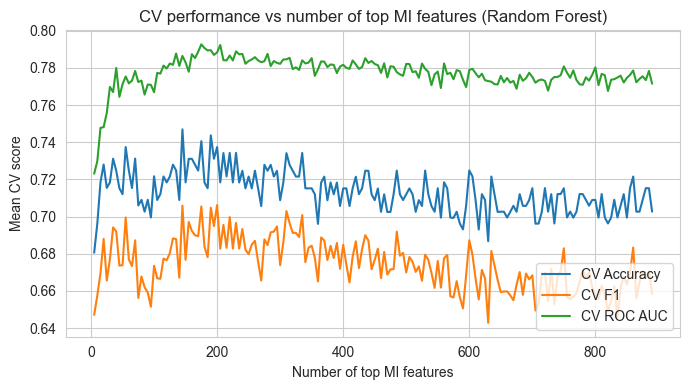


===== Evaluating KBest feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.658333  0.630255    0.721743
1       10     0.671230  0.645395    0.725131
2       15     0.658383  0.642995    0.743326
3       20     0.655208  0.639322    0.756581
4       25     0.671131  0.649811    0.759352
..     ...          ...       ...         ...
173    870     0.715278  0.677821    0.772038
174    875     0.705952  0.657641    0.771982
175    880     0.705804  0.664679    0.773551
176    885     0.705853  0.657662    0.774388
177    890     0.702679  0.652902    0.775736

[178 rows x 4 columns]

Best N by CV F1 (KBest): 790
Top_N          790.000000
CV_Accuracy      0.724851
CV_F1            0.684499
CV_ROC_AUC       0.764171
Name: 157, dtype: float64


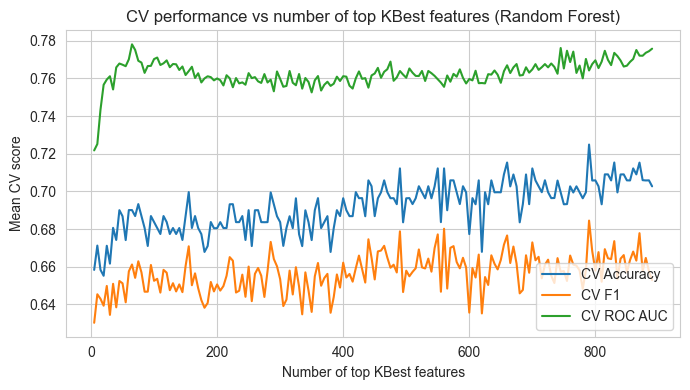


===== Evaluating Lasso feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.566419  0.559801    0.666154
1       10     0.759772  0.733736    0.805213
2       15     0.753274  0.727878    0.833473
3       20     0.778522  0.754896    0.848569
4       25     0.781796  0.751463    0.848923
..     ...          ...       ...         ...
173    870     0.712252  0.666746    0.775967
174    875     0.708929  0.663699    0.774804
175    880     0.702629  0.654829    0.772182
176    885     0.705804  0.660006    0.772566
177    890     0.702629  0.659250    0.775541

[178 rows x 4 columns]

Best N by CV F1 (Lasso): 20
Top_N          20.000000
CV_Accuracy     0.778522
CV_F1           0.754896
CV_ROC_AUC      0.848569
Name: 3, dtype: float64


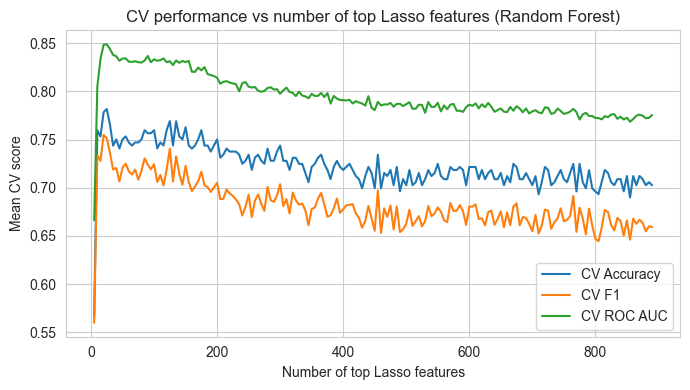

In [16]:


best_shap, shap_cv_table = evaluate_rf_feature_method(
    "SHAP", shap_features, X_train, y_train, base_model
)

best_mi, mi_cv_table = evaluate_rf_feature_method(
    "MI", mi_features, X_train, y_train, base_model
)

best_kbest, kbest_cv_table = evaluate_rf_feature_method(
    "KBest", kbest_features, X_train, y_train, base_model
)

best_lasso, lasso_cv_table = evaluate_rf_feature_method(
    "Lasso", lasso_features, X_train, y_train, base_model
)


## Train Model Features

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_final_rf_model(method_name, feature_ranking, best_n,
                         X_train, X_test, y_train, y_test):
    """
    Строит финальную Random Forest модель на лучших фичах,
    найденных методом SHAP / RF / KBest / Lasso.

    method_name: строка ('SHAP', 'RF', 'KBest', 'Lasso')
    feature_ranking: pd.Series — ранжированные фичи
    best_n: количество лучших фич из evaluate_rf_feature_method()
    """

    print(f"\n===== FINAL Random Forest model using {best_n} {method_name} features =====")

    # выбираем топ-N фич
    top_feats = feature_ranking.head(best_n).index.tolist()

    # создаём финальную Random Forest модель
    final_model = RandomForestClassifier(
        n_estimators=best_n,      # число деревьев = число фич
        random_state=42,
        class_weight="balanced"
    )

    # обучение модели
    final_model.fit(X_train[top_feats], y_train)

    # предсказание

    y_pred = final_model.predict(X_test[top_feats])
    y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

    # считаем метрики
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    # выводим отчёт
    print(f"\nFinal model performance ({method_name}) on TEST:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    log_result(
    method_name,
    model_type="Baseline_RF",
    n_features=best_n,
    metrics={
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    },
    params={
        "n_estimators": X_train.shape[1],
        "class_weight": "balanced"
    },
    stage="final"
)


    # 7возвращаем модель и метрики
    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats
    }


In [18]:

final_shap_model, shap_metrics = train_final_rf_model(
    "SHAP", shap_features, best_shap, X_train, X_test, y_train, y_test
)

final_mi_model, mi_metrics = train_final_rf_model(
    "MI", mi_features, best_mi, X_train, X_test, y_train, y_test
)

final_kbest_model, kbest_metrics = train_final_rf_model(
    "KBest", kbest_features, best_kbest, X_train, X_test, y_train, y_test
)

final_lasso_model, lasso_metrics = train_final_rf_model(
    "Lasso", lasso_features, best_lasso, X_train, X_test, y_train, y_test
)



===== FINAL Random Forest model using 20 SHAP features =====

Final model performance (SHAP) on TEST:
Accuracy:  0.6500
Precision: 0.6364
Recall:    0.5676
F1 score:  0.6000
ROC AUC:   0.7282

===== FINAL Random Forest model using 200 MI features =====

Final model performance (MI) on TEST:
Accuracy:  0.7125
Precision: 0.7500
Recall:    0.5676
F1 score:  0.6462
ROC AUC:   0.7989

===== FINAL Random Forest model using 790 KBest features =====

Final model performance (KBest) on TEST:
Accuracy:  0.7250
Precision: 0.7778
Recall:    0.5676
F1 score:  0.6562
ROC AUC:   0.8033

===== FINAL Random Forest model using 20 Lasso features =====

Final model performance (Lasso) on TEST:
Accuracy:  0.6500
Precision: 0.6452
Recall:    0.5405
F1 score:  0.5882
ROC AUC:   0.7225



## Optuna

In [19]:
def tune_rf_optuna(method_name, feature_ranking, best_n,
                   X_train, X_test, y_train, y_test, n_trials=100):

    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 60, 160),
            "max_depth": trial.suggest_int("max_depth", 4, 8),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.1, 0.2]),
            "bootstrap": True,
            "class_weight": "balanced",
            "random_state": 42,
            "n_jobs": -1,
        }

        model = RandomForestClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc = cross_val_score(
            model, X_train_fs, y_train,
            cv=cv, scoring="roc_auc", n_jobs=-1
        ).mean()

        return auc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params

    final_model = RandomForestClassifier(
        **best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_train_fs, y_train)

    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    return {
        "Method": method_name,
        "Model": "RandomForest",
        "Feature_Ranking": feature_ranking,
        "Best_N": best_n,
        "AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Params": study.best_params,
    }


## Model Feautures Tunning (Optuna + gboost)

In [20]:
def tune_advanced_tree_model(method_name, feature_ranking, best_n,
                             X_train, X_test, y_train, y_test,
                             model_type="gboost", n_trials=50):

    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 80, 250),
            "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.15),
            "max_depth": trial.suggest_int("max_depth", 2, 4),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        }

        model = GradientBoostingClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc = cross_val_score(
            model,
            X_train_fs,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        ).mean()

        return auc

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params

    final_model = GradientBoostingClassifier(random_state=42, **best_params)
    final_model.fit(X_train_fs, y_train)

    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    return {
        "Method": method_name,
        "Model": "RandomForest",
        "Feature_Ranking": feature_ranking,
        "Best_N": best_n,
        "AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Params": study.best_params,
    }



## Result

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

methods = {
    "SHAP": (shap_features, best_shap),
    "MI": (mi_features, best_mi),
    "KBest": (kbest_features, best_kbest),
    "Lasso": (lasso_features, best_lasso),
}

rf_rows = []
gb_rows = []

for name, (ranking, best_n) in methods.items():

    rf_rows.append(
        tune_rf_optuna(name, ranking, best_n,
                       X_train, X_test, y_train, y_test)
    )

    gb_rows.append(
        tune_advanced_tree_model(name, ranking, best_n,
                                 X_train, X_test, y_train, y_test,
                                 model_type="gboost")
    )

# Таблицы
rf_results_df = pd.DataFrame(rf_rows)
gb_results_df = pd.DataFrame(gb_rows)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [24]:
rf_results_df

,Method,Model,Feature_Ranking,Best_N,AUC,Accuracy,Precision,Recall,F1,Params
0,SHAP,RandomForest,RDK_2048_865 0.007579 PEOE_VSA9 0.0...,20,0.752357,0.7000,0.696970,0.621622,0.657143,"{'n_estimators': 74, 'max_depth': 8, 'min_samp..."
1,MI,RandomForest,MaxPartialCharge 0.152312 BCUT2D_MWHI ...,200,0.798869,0.6625,0.647059,0.594595,0.619718,"{'n_estimators': 119, 'max_depth': 8, 'min_sam..."
2,KBest,RandomForest,RDK_2048_865 44.566735 RDK_2048_429 ...,790,0.786298,0.7125,0.718750,0.621622,0.666667,"{'n_estimators': 117, 'max_depth': 5, 'min_sam..."
3,Lasso,RandomForest,RDK_2048_597 0.962426 RDK_2048_1901 ...,20,0.698303,0.6375,0.617647,0.567568,0.591549,"{'n_estimators': 78, 'max_depth': 7, 'min_samp..."


In [25]:
gb_results_df

,Method,Model,Feature_Ranking,Best_N,AUC,Accuracy,Precision,Recall,F1,Params
0,SHAP,RandomForest,RDK_2048_865 0.007579 PEOE_VSA9 0.0...,20,0.770585,0.7000,0.696970,0.621622,0.657143,"{'n_estimators': 87, 'learning_rate': 0.036666..."
1,MI,RandomForest,MaxPartialCharge 0.152312 BCUT2D_MWHI ...,200,0.803268,0.7125,0.769231,0.540541,0.634921,"{'n_estimators': 110, 'learning_rate': 0.13514..."
2,KBest,RandomForest,RDK_2048_865 44.566735 RDK_2048_429 ...,790,0.761157,0.6625,0.647059,0.594595,0.619718,"{'n_estimators': 111, 'learning_rate': 0.03568..."
3,Lasso,RandomForest,RDK_2048_597 0.962426 RDK_2048_1901 ...,20,0.679447,0.6125,0.575000,0.621622,0.597403,"{'n_estimators': 109, 'learning_rate': 0.11306..."


In [26]:
best_rf_row = rf_results_df.loc[rf_results_df["AUC"].idxmax()]
rf_best_params = best_rf_row["Params"]
rf_best_n = best_rf_row["Best_N"]
rf_best_method = best_rf_row["Method"]

best_gb_row = gb_results_df.loc[gb_results_df["AUC"].idxmax()]
gb_best_params = best_gb_row["Params"]
gb_best_n = best_gb_row["Best_N"]
gb_best_method = best_gb_row["Method"]

print("Best RF:", rf_best_method, rf_best_n, rf_best_params)
print("Best GB:", gb_best_method, gb_best_n, gb_best_params)


Best RF: MI 200 {'n_estimators': 119, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.2}
Best GB: MI 200 {'n_estimators': 110, 'learning_rate': 0.13514852800957228, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 2}


## Dinamic

In [27]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def build_weighted_ensemble(method_name, feature_ranking, best_n,
                            X_train, X_test, y_train, y_test,
                            rf_best_params, gb_best_params):

    print(f"\n===== BUILD WEIGHTED ENSEMBLE ({method_name}, top {best_n}) =====")

    # --- 1) TOP FEATURES ---
    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    # --- 2) BEST RF ---
    tuned_rf = RandomForestClassifier(
        **rf_best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    tuned_rf.fit(X_train_fs, y_train)

    # --- 3) BEST GB ---
    tuned_gb = GradientBoostingClassifier(
        **gb_best_params,
        random_state=42
    )
    tuned_gb.fit(X_train_fs, y_train)

    # --- 4) Weighted soft voting ---
    voting = VotingClassifier(
        estimators=[
            ("gb", tuned_gb),
            ("rf", tuned_rf)
        ],
        voting="soft",
        weights=[3, 1],  # GB сильнее → больший вес
        n_jobs=-1
    )

    voting.fit(X_train_fs, y_train)

    # --- 5) Evaluate all ---
    models = {
        "RF": tuned_rf,
        "GB": tuned_gb,
        "WEIGHTED_VOTING": voting
    }

    results = {}

    for name, model in models.items():
        y_pred = model.predict(X_test_fs)
        y_prob = model.predict_proba(X_test_fs)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        print(f"\n===== {name} RESULTS =====")
        print(f"AUC:       {auc:.4f}")
        print(f"F1:        {f1:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"Accuracy:  {acc:.4f}")

        results[name] = {
            "AUC": auc, "F1": f1, "Precision": prec,
            "Recall": rec, "Accuracy": acc
        }

    return {
        "Models": models,
        "Results": results,
        "Top_Features": top_feats
    }


In [28]:
ensemble_results = build_weighted_ensemble(
    method_name="AUTO",
    feature_ranking=shap_features,
    best_n=best_shap,
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    rf_best_params=rf_best_params,
    gb_best_params=gb_best_params
)



===== BUILD WEIGHTED ENSEMBLE (AUTO, top 20) =====

===== RF RESULTS =====
AUC:       0.7744
F1:        0.6667
Precision: 0.6579
Recall:    0.6757
Accuracy:  0.6875

===== GB RESULTS =====
AUC:       0.7423
F1:        0.6667
Precision: 0.6857
Recall:    0.6486
Accuracy:  0.7000

===== WEIGHTED_VOTING RESULTS =====
AUC:       0.7561
F1:        0.6667
Precision: 0.6857
Recall:    0.6486
Accuracy:  0.7000


In [29]:

import optuna
import numpy as np
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def tune_weighted_ensemble(method_name, feature_ranking, best_n,
                           X_train, X_test, y_train, y_test,
                           rf_best_params, gb_best_params, n_trials=40):

    print(f"\n===== OPTUNA WEIGHTED ENSEMBLE ({method_name}, top {best_n}) =====")

    # --- 1) Top features ---
    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    # --- 2) Create tuned base models ---
    tuned_rf = RandomForestClassifier(
        **rf_best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    tuned_gb = GradientBoostingClassifier(
        **gb_best_params,
        random_state=42
    )

    tuned_rf.fit(X_train_fs, y_train)
    tuned_gb.fit(X_train_fs, y_train)

    # --- 3) Optuna objective: optimize weights ---
    def objective(trial):
        w_gb = trial.suggest_float("w_gb", 1.0, 10.0)
        w_rf = trial.suggest_float("w_rf", 0.1, 5.0)

        model = VotingClassifier(
            estimators=[
                ("gb", tuned_gb),
                ("rf", tuned_rf)
            ],
            voting="soft",
            weights=[w_gb, w_rf],
            n_jobs=-1
        )

        model.fit(X_train_fs, y_train)
        y_prob = model.predict_proba(X_test_fs)[:, 1]

        return roc_auc_score(y_test, y_prob)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\nBest Ensemble AUC:", study.best_value)
    print("Best Weights:", study.best_params)

    # --- 4) Final model with best weights ---
    best_w_gb = study.best_params["w_gb"]
    best_w_rf = study.best_params["w_rf"]

    final_model = VotingClassifier(
        estimators=[
            ("gb", tuned_gb),
            ("rf", tuned_rf)
        ],
        voting="soft",
        weights=[best_w_gb, best_w_rf],
        n_jobs=-1
    )

    final_model.fit(X_train_fs, y_train)

    # --- 5) Final evaluation ---
    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n===== FINAL OPTIMIZED WEIGHTED ENSEMBLE RESULTS =====")
    print(f"AUC:       {auc:.4f}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1:        {f1:.4f}")

    return final_model, {
        "AUC": auc, "Accuracy": acc, "Precision": prec,
        "Recall": rec, "F1": f1,
        "Weights": study.best_params,
        "Top_Features": top_feats
    }


In [30]:
final_model, final_metrics = tune_weighted_ensemble(
    method_name = shap_features,                    # например "SHAP"
    feature_ranking = shap_features,                 # или объединённые фичи
    best_n = best_shap,
    X_train = X_train,
    X_test  = X_test,
    y_train = y_train,
    y_test  = y_test,
    rf_best_params = rf_best_params,
    gb_best_params = gb_best_params,
    n_trials = 40
)



===== OPTUNA WEIGHTED ENSEMBLE (RDK_2048_865     0.007579
PEOE_VSA9        0.007280
RDK_2048_429     0.005414
EState_VSA7      0.004356
RDK_2048_1163    0.003847
                   ...   
RDK_2048_1640    0.000165
RDK_2048_47      0.000164
RDK_2048_35      0.000161
RDK_2048_978     0.000161
RDK_2048_1663    0.000144
Length: 891, dtype: float64, top 20) =====


  0%|          | 0/40 [00:00<?, ?it/s]


Best Ensemble AUC: 0.7718416090509114
Best Weights: {'w_gb': 1.0044953233504639, 'w_rf': 4.815929422520611}

===== FINAL OPTIMIZED WEIGHTED ENSEMBLE RESULTS =====
AUC:       0.7718
Accuracy:  0.6500
Precision: 0.6286
Recall:    0.5946
F1:        0.6111


In [31]:
import numpy as np
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import matplotlib.pyplot as plt


###############################################################################
# 1. OPTUNA RF (inner loop)
###############################################################################

def optuna_tune_rf(X_train, y_train, n_trials=70):

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    def objective(trial):

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 150, 600),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 8),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 5),
            "max_features": trial.suggest_float("max_features", 0.05, 0.25),
            "bootstrap": True,
            "class_weight": "balanced",
            "random_state": 42,
            "n_jobs": -1
        }

        model = RandomForestClassifier(**params)

        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        aucs = []

        for tr_idx, val_idx in inner_cv.split(X_train, y_train):

            X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

            # SMOTE INSIDE CV
            sm = SMOTE(random_state=42, k_neighbors=2)
            X_tr_sm, y_tr_sm = sm.fit_resample(X_tr, y_tr)

            model.fit(X_tr_sm, y_tr_sm)
            pred = model.predict_proba(X_val)[:, 1]

            aucs.append(roc_auc_score(y_val, pred))

        return float(np.mean(aucs))

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    return study.best_params


###############################################################################
# 2. NESTED CV (outer loop)
###############################################################################

def nested_cv_evaluate(X_train, y_train):

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = []
    best_params_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train)):

        print(f"\n===== OUTER FOLD {fold+1}/5 =====")

        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

        print("Running Optuna inner CV...")
        best_params = optuna_tune_rf(X_tr, y_tr)
        best_params_list.append(best_params)

        model = RandomForestClassifier(
            class_weight="balanced",
            random_state=42,
            n_jobs=-1,
            **best_params
        )

        sm = SMOTE(random_state=42, k_neighbors=2)
        X_tr_sm, y_tr_sm = sm.fit_resample(X_tr, y_tr)

        model.fit(X_tr_sm, y_tr_sm)
        pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, pred)
        scores.append(auc)

        print(f"Fold AUC: {auc:.4f}")

    print("\n===== NESTED CV COMPLETE =====")
    print(f"Mean AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

    return best_params_list


###############################################################################
# 3. FINAL ENSEMBLES (Stacking + Voting)
###############################################################################

def build_ensembles(X_train, y_train, best_params):

    tuned_rf = RandomForestClassifier(
        class_weight="balanced", random_state=42, n_jobs=-1, **best_params
    )

    sm = SMOTE(random_state=42, k_neighbors=2)
    X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)

    tuned_rf.fit(X_tr_sm, y_tr_sm)

    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=250,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.7,
        colsample_bytree=0.6,
        random_state=42,
        n_jobs=-1
    )

    lr_model = LogisticRegression(max_iter=800, class_weight="balanced")

    stacking = StackingClassifier(
        estimators=[("rf", tuned_rf), ("xgb", xgb_model), ("lr", lr_model)],
        final_estimator=RandomForestClassifier(
            n_estimators=300, max_depth=5, class_weight="balanced",
            random_state=42, n_jobs=-1
        ),
        stack_method="predict_proba",
        passthrough=False,
        n_jobs=-1
    )

    stacking.fit(X_tr_sm, y_tr_sm)

    voting = VotingClassifier(
        estimators=[("rf", tuned_rf), ("xgb", xgb_model), ("lr", lr_model)],
        voting="soft",
        n_jobs=-1
    )

    voting.fit(X_tr_sm, y_tr_sm)

    return tuned_rf, stacking, voting


###############################################################################
# 4. Evaluation on REAL test set
###############################################################################

def eval_model(name, model, X_test, y_test):
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:, 1]

    print(f"\n--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("Precision:", precision_score(y_test, pred))
    print("Recall:", recall_score(y_test, pred))
    print("F1:", f1_score(y_test, pred))
    print("AUC:", roc_auc_score(y_test, prob))


###############################################################################
# 5. ROC + PR plots
###############################################################################

def plot_curves(model, X_test, y_test, name):

    from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

    prob = model.predict_proba(X_test)[:, 1]

    RocCurveDisplay.from_predictions(y_test, prob)
    plt.title(f"ROC Curve – {name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, prob)
    plt.title(f"PR Curve – {name}")
    plt.show()


In [ ]:
best_params_list = nested_cv_evaluate(X_train, y_train)

# выбираем медианные параметры
from statistics import median
best_params = best_params_list[len(best_params_list)//2]

# финальные ансамбли
rf, stack, vote = build_ensembles(X_train, y_train, best_params)

# оценка на тесте
eval_model("Tuned RF", rf, X_test, y_test)
eval_model("Stacking", stack, X_test, y_test)
eval_model("Soft Voting", vote, X_test, y_test)

# графики
plot_curves(vote, X_test, y_test, "Soft Voting")



===== OUTER FOLD 1/5 =====
Running Optuna inner CV...



=== Testing top 5 SHAP features ===
Best parameters: {'n_estimators': np.int64(40), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4, 'bootstrap': False}
Accuracy: 0.667 | ROC-AUC: 0.674

=== Testing top 6 SHAP features ===
Best parameters: {'n_estimators': np.int64(40), 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}
Accuracy: 0.424 | ROC-AUC: 0.559

=== Testing top 7 SHAP features ===
Best parameters: {'n_estimators': np.int64(120), 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': None, 'bootstrap': False}
Accuracy: 0.576 | ROC-AUC: 0.593

=== Testing top 8 SHAP features ===
Best parameters: {'n_estimators': np.int64(120), 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': None, 'bootstrap': False}
Accuracy: 0.576 | ROC-AUC: 0.574

=== Testing top 9 SHAP features ===
Best parameters: {'n_estimators': np.int64(20), 'min_samples

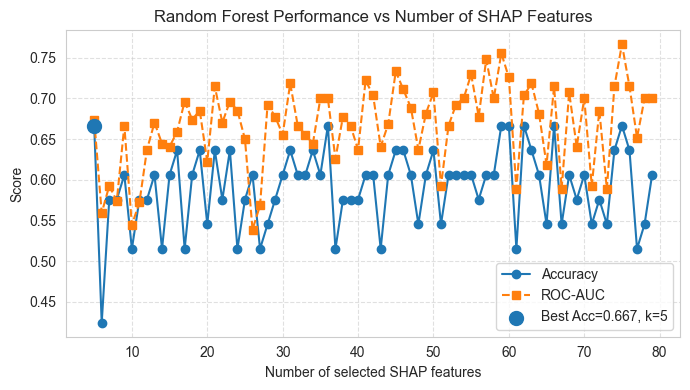


Best Accuracy = 0.667, ROC-AUC = 0.674, k = 5


In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = shap_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 80, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")



=== Testing top 5 SHAP features ===
Best parameters: {'n_estimators': np.int64(100), 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.5, 'max_depth': 3, 'bootstrap': False}
Accuracy: 0.636 | ROC-AUC: 0.711

=== Testing top 6 SHAP features ===
Best parameters: {'n_estimators': np.int64(100), 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': False}
Accuracy: 0.667 | ROC-AUC: 0.717

=== Testing top 7 SHAP features ===
Best parameters: {'n_estimators': np.int64(40), 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 4, 'bootstrap': False}
Accuracy: 0.697 | ROC-AUC: 0.724

=== Testing top 8 SHAP features ===
Best parameters: {'n_estimators': np.int64(40), 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.7, 'max_depth': 4, 'bootstrap': True}
Accuracy: 0.576 | ROC-AUC: 0.683

=== Testing top 9 SHAP features ===
Best parameters: {'n_estimators': np.int64(20), 'min_samples_split'

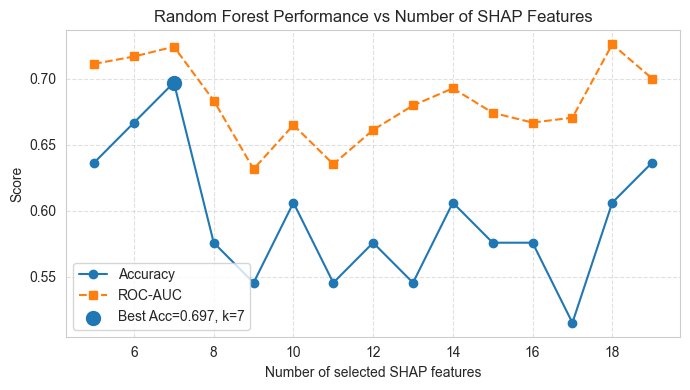


Best Accuracy = 0.697, ROC-AUC = 0.724, k = 7


In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = lasso_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 20, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")



=== Testing top 5 SHAP features ===
Best parameters: {'n_estimators': np.int64(100), 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3, 'bootstrap': False}
Accuracy: 0.667 | ROC-AUC: 0.691

=== Testing top 6 SHAP features ===
Best parameters: {'n_estimators': np.int64(60), 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
Accuracy: 0.576 | ROC-AUC: 0.678

=== Testing top 7 SHAP features ===
Best parameters: {'n_estimators': np.int64(60), 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 6, 'bootstrap': True}
Accuracy: 0.636 | ROC-AUC: 0.741

=== Testing top 8 SHAP features ===
Best parameters: {'n_estimators': np.int64(100), 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 4, 'bootstrap': True}
Accuracy: 0.606 | ROC-AUC: 0.681

=== Testing top 9 SHAP features ===
Best parameters: {'n_estimators': np.int64(60), 'min_samples_split'

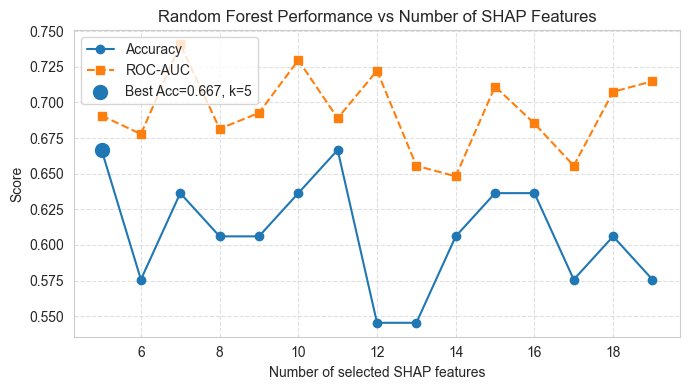


Best Accuracy = 0.667, ROC-AUC = 0.691, k = 5


In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = mi_features   # Series: feature -> importance

# Гиперпараметры для Random Forest
param_dist = {
    "n_estimators": np.arange(20, 160, 20),
    "max_depth": [3, 4, 5, 6, 7, None],
    "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0],
    "bootstrap": [True, False],
}

results = []

# Sweep по числу признаков
for k in range(5, 20, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_dist,
        n_iter=60,
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    search.fit(X_train_sel, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_sel)
    y_prob = best_model.predict_proba(X_test_sel)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((k, acc, auc))

    print(f"Best parameters: {search.best_params_}")
    print(f"Accuracy: {acc:.3f} | ROC-AUC: {auc:.3f}")

# Анализ результатов
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]
auc_scores = results[:, 2]

# Лучший по Accuracy
best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_acc = accuracies[best_index]
best_auc = auc_scores[best_index]

# Графики
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='Accuracy')
plt.plot(feature_counts, auc_scores, 's--', label='ROC-AUC')
plt.scatter(best_k, best_acc, s=100, zorder=5,
            label=f'Best Acc={best_acc:.3f}, k={best_k}')
plt.title('Random Forest Performance vs Number of SHAP Features')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nBest Accuracy = {best_acc:.3f}, ROC-AUC = {best_auc:.3f}, k = {best_k}")


Tento kód postupne prechádza rôzne počty najdôležitejších SHAP-príznakov (od 5 do 79) a pre každý takýto výber spúšťa RandomizedSearchCV, ktorý hľadá najlepšiu konfiguráciu hyperparametrov pre Random Forest. Vďaka tomu sa zároveň optimalizuje aj samotná veľkosť príznakového priestoru – teda zisťuje sa, koľko príznakov modelu skutočne pomáha. Analýza ukazuje, že najvyššia presnosť sa dosiahla pri 79 SHAP príznakoch, kde model dosiahol Accuracy = 0.727 a ROC-AUC = 0.730, čo znamená, že väčší počet SHAP príznakov zachytáva viac informácie bez pretrénovania. Záverečný graf vizuálne ukazuje trend metrík pri narastajúcom počte príznakov a pomáha vybrať optimálne množstvo pre finálny model.

In [23]:
final_table = save_results_table("../all_results.xlsx")
print(final_table)

Saved full results table to all_results.xlsx
   Method        Model          Stage  Top_Features  Accuracy  Precision  \
0    SHAP  Baseline_RF          final             5  0.636364   0.666667   
1      MI  Baseline_RF          final            10  0.636364   0.714286   
2   KBest  Baseline_RF          final            15  0.636364   0.687500   
3   Lasso  Baseline_RF          final            10  0.606061   0.647059   
4    SHAP    Optuna_RF         optuna             5  0.666667   0.705882   
5      MI    Optuna_RF         optuna            10  0.606061   0.692308   
6   KBest    Optuna_RF         optuna            15  0.606061   0.666667   
7   Lasso    Optuna_RF         optuna            10  0.606061   0.631579   
8    SHAP   extratrees  simple_tuning             5  0.606061   0.647059   
9      MI   extratrees  simple_tuning             5  0.636364   0.650000   
10  KBest   extratrees  simple_tuning             5  0.636364   0.666667   
11  Lasso   extratrees  simple_tuning      